### Start of Variant Analysis 

array([<matplotlib.axes._subplots.AxesSubplot object at 0x115d3fbd0>,
      dtype=object)

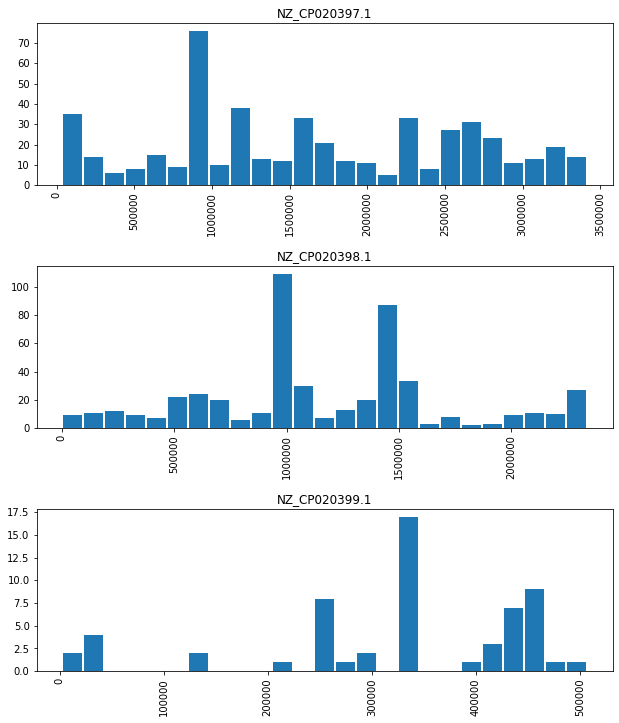

In [117]:
import pandas 
import matplotlib.pyplot as plt

#reads in table generated 
variants = pandas.read_excel("/Users/sarahharrison/Downloads/as_merged_excel.xlsx", sep="\t")
#Groups table by chromosome and sorts by position value
variants.groupby('Chromosome').apply(lambda x: x.sort_values('Position'))
#Makes histogram of position values in bins of 25 
###HOW to ONE y axis label and ONE x label for each want Number of Mutations to be y label, and chromosome position bins to be x label 
### also would like to remove before the 0 and after the last point last data point to remove extra space on sides
### need to add title and maybe change color of bars and make chromosome names looks better 
pos_his = variants.hist(column="Position", by="Chromosome", bins=25, grid=False, figsize=(10,12), layout=(3,1), zorder=2, rwidth= .9)
pos_his

In [123]:
#Function returns table of regions with top 10 highest numbers of mutations based on specified 
##bin size in each chromosome 
#Input is dataframe containing "Position" column with all positions which contain mutations as well dataframe must also contain "Chromosome" 


def getMutRegions(data, bins):
    #makes list of chromosomes 
    chroms = list(data.Chromosome.unique()) 
    #creates blank dataframe with desired columns 
    all_reg = pandas.DataFrame(columns=['Regions', '# SNPs', '% Total on Chrom', 'Chromosome'])
    #iterates through chrom list
    for ch in chroms:
        #keeps rows based on chromosome 
        each_chrom = data[data['Chromosome'] == ch]
        #gets positions and splits values into specified bin number
        values = each_chrom['Position'].value_counts(bins=bins)
        #new_index = list(values.index)
        #print(new_index)
        #gives fraction of total mutatons on chromosome contained in each each bin region and multiplies by 100 to give percent of total 
        percent_total_chrom = each_chrom['Position'].value_counts(bins=bins, normalize=True) * 100
        #makes new dataframe with desired infomation
        df1 = pandas.DataFrame({'Regions': values.index, '# SNPs' : values.values, '% Total on Chrom': percent_total_chrom.values, 'Chromosome': ch})
        #appends each chromosome info to new dataframe and so easily can group table by chromosome and returns it 
        all_reg = all_reg.append(df1, ignore_index=True)
    return all_reg

#creating dataframe from above variants table and chose bin size of 100 
mutation_regions = getMutRegions(variants, 100)
#only want regions with signifcantly higher proportions of mutations than would be assumed by equal distribution. 
#Split into 100 bins so theoretically if mutations random and selective pressure/mutagenesis low, each region should contain approximately 1% of total mutations on the chromosome
#This is very approximate so decided would only consider regions containing x10 of that because this may mean there is some kind of selective pressure or something else in these regions containing a significant enrichment of mutations 
highest_muts = mutation_regions.loc[mutation_regions['% Total on Chrom'] >= 10]
highest_muts

    

,Regions,# SNPs,% Total on Chrom,Chromosome
0,"(878042.25, 911902.18]",59,11.871227,NZ_CP020397.1
100,"(1473014.46, 1496390.88]",83,16.500994,NZ_CP020398.1
101,"(958733.22, 982109.64]",82,16.302187,NZ_CP020398.1
200,"(340446.81, 345497.24]",17,28.813559,NZ_CP020399.1
201,"(446505.84, 451556.27]",8,13.559322,NZ_CP020399.1
202,"(441455.41, 446505.84]",7,11.864407,NZ_CP020399.1
203,"(244488.64, 249539.07]",6,10.169492,NZ_CP020399.1


In [119]:
import re

def RegionGFF_input(muts_df):
    regions_dict = {}
    for x in muts_df.Chromosome:
        regions_dict[x] = []
    for reg,chrom in zip(muts_df.Regions, muts_df.Chromosome): 
        new = str(reg)
        no_char = new.rstrip(']').lstrip('(')
        mylist = no_char.split(',')
        rounded_nums = []
        for nums in mylist:
            num = round(float(nums))
            rounded_nums.append(num)
        for k,v in regions_dict.items():
            if chrom == k:
                v.append(rounded_nums)
    return(regions_dict)

GFF_dict = RegionGFF_input(highest_muts)
print(GFF_dict)
    

{'NZ_CP020397.1': [[878042, 911902]], 'NZ_CP020398.1': [[1473014, 1496391], [958733, 982110]], 'NZ_CP020399.1': [[340447, 345497], [446506, 451556], [441455, 446506], [244489, 249539]]}


In [120]:
import gffutils
#reads in GFF file downloaded from NCBI of reference strain
my_gff = "/Users/sarahharrison/Downloads/GCF_003019965.1_ASM301996v1_genomic.gff"


def makeCDSFrame(the_GFF_dict, my_gff):
    #makes database of gff 
    db = gffutils.create_db(my_gff, dbfn='GFF.db', force=True, keep_order=True,merge_strategy='merge', sort_attribute_values=True)
    
    all_genes = pandas.DataFrame(columns=['Protein Product', 'Start_Pos', 'Stop_Pos', 'Chromosome', 'Strand'])

    for key,value in the_GFF_dict.items():
        for loc in value:

            gene_list = list(db.region(region=(key,
                                               loc[0], loc[1])))
            #print(gene_list)
            the_gene_list = []
            start_list = []
            stop_list = []
            protein_id_list = []
            strand_list = []
            product_list = []
            for thing in gene_list:
                if thing.featuretype == 'CDS':
                    strand_list.append(thing.strand)
                    attributes = dict(thing.attributes)
                    gene_name = attributes['Parent']
                    the_gene_list.append(gene_name[0].split('-')[1])
                    start_list.append(thing.start)
                    stop_list.append(thing.stop)
                    product = attributes['product']
                    product_list.append(product[0])
            gene_data = {'Protein Product': product_list, 'Start_Pos' : start_list, 'Stop_Pos': stop_list, 'Chromosome': key, 'Strand': strand_list}
            data_fr = pandas.DataFrame(data=gene_data, index=the_gene_list)
            all_genes = all_genes.append(data_fr)
            
    all_genes.index.name = "Gene"
    dedup = all_genes.drop_duplicates()
    return(dedup)

high_region_gene_data = makeCDSFrame(GFF_dict, my_gff)
high_region_gene_data
                


,Protein Product,Start_Pos,Stop_Pos,Chromosome,Strand
Gene,,,,,
A8H40_RS04365,2-hydroxyacid dehydrogenase,878089,879087,NZ_CP020397.1,-
A8H40_RS04370,LysR family transcriptional regulator,879122,880105,NZ_CP020397.1,-
A8H40_RS04375,hypothetical protein,880456,880857,NZ_CP020397.1,-
A8H40_RS04380,alanine--glyoxylate aminotransferase family pr...,880843,882054,NZ_CP020397.1,+
A8H40_RS04385,helix-turn-helix transcriptional regulator,882073,883008,NZ_CP020397.1,-
...,...,...,...,...,...
A8H40_RS28745,BON domain-containing protein,245582,246061,NZ_CP020399.1,-
A8H40_RS28750,hypothetical protein,246221,246772,NZ_CP020399.1,-
A8H40_RS28755,low affinity iron permease family protein,246873,247385,NZ_CP020399.1,-


In [122]:
all_mutations = getMutRegions(variants, 10000)
all_mut_regions = all_mutations.loc[all_mutations['# SNPs'] > 0]

#all_mut_regions["# SNPs"].sum() made sure that Number is same as Number of locations 



1059

In [182]:
all_GFF_dict = RegionGFF_input(all_mut_regions)

In [125]:
def makeAllGeneFrame(the_GFF_dict, my_gff):
    #makes database of gff 
    db = gffutils.create_db(my_gff, dbfn='GFF.db', force=True, keep_order=True,merge_strategy='merge', sort_attribute_values=True)
    
    all_genes = pandas.DataFrame(columns=['Biotype', 'Start_Pos', 'Stop_Pos', 'Strand', 'Chromosome'])

    for key,value in the_GFF_dict.items():
        for loc in value:

            gene_list = list(db.region(region=(key,
                                               loc[0], loc[1])))
            
            the_gene_list = []
            start_list = []
            stop_list = []
            biotype_list = []
            strand_list = []
            for item in gene_list:
                if item.featuretype == 'gene':
                    strand_list.append(item.strand)
                    attributes = dict(item.attributes)
                    my_gene = item.id.split('-')[1]
                    the_gene_list.append(my_gene)
                    start_list.append(item.start)
                    stop_list.append(item.stop)
                    biotype = attributes['gene_biotype']
                    biotype_list.append(biotype[0])
                    
            gene_data = {'Biotype': biotype_list, 'Start_Pos' : start_list, 'Stop_Pos': stop_list, 'Strand': strand_list, 'Chromosome': key}
            data_fr = pandas.DataFrame(data=gene_data, index=the_gene_list)
            all_genes = all_genes.append(data_fr)
            
    all_genes.index.name = "Gene"
    dedup = all_genes.drop_duplicates()
    return(dedup)
            

In [181]:
all_genes_data = makeAllGeneFrame(all_GFF_dict, my_gff)
all_cds_data = makeCDSFrame(all_GFF_dict, my_gff)


In [179]:

group_pos = variants.groupby('Chromosome')

grouped_ss = all_cds_data.groupby('Chromosome')

gene_locs = {}

for chrom, pos in group_pos:
    for ch, region in grouped_ss:
        if chrom == ch:
            positions = pos['Position'].to_list()
            for posi in positions:
                for row in region.itertuples():
                    if posi >= row.Start_Pos and posi <= row.Stop_Pos:
                        if row.Index in gene_locs:
                            gene_locs[row.Index].append(posi)
                        else:
                            gene_locs[row.Index] = [posi]
            



 
    

In [180]:
mut_as_nums = {}
for k,v in gene_locs.items():
    mut_as_nums[k] = len(v)


In [178]:
import numpy as np

NaN = np.nan
all_cds_data['Count'] = 0
all_cds_data

for i,row in all_cds_data.iterrows():
    if i in mut_as_nums:
        all_cds_data.at[i,'Count'] = mut_as_nums[i]
    
cds_genes = all_cds_data.loc[all_cds_data['Count'] > 0]
cds_genes.sort_values(by='Count',inplace=True, ascending=False)
top_15 = cds_genes.head(15)
top_15

756


/Users/sarahharrison/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,Protein Product,Start_Pos,Stop_Pos,Chromosome,Strand,Count
Gene,,,,,,
A8H40_RS21335,BapA prefix-like domain-containing protein,970334,978448,NZ_CP020398.1,+,80
A8H40_RS23590,ATP-dependent metallopeptidase FtsH/Yme1/Tma f...,1473409,1475376,NZ_CP020398.1,+,79
A8H40_RS04480,S-layer family protein,905635,911430,NZ_CP020397.1,+,56
A8H40_RS05990,UDP-glucose/GDP-mannose dehydrogenase family p...,1202377,1203777,NZ_CP020397.1,+,32
A8H40_RS21405,DUF1275 domain-containing protein,990263,991018,NZ_CP020398.1,-,20
A8H40_RS13585,hypothetical protein,2748327,2748685,NZ_CP020397.1,-,18
A8H40_RS23950,PAS domain-containing sensor histidine kinase,1555236,1557290,NZ_CP020398.1,+,18
A8H40_RS27630,collagen-like triple helix repeat-containing p...,2336935,2339577,NZ_CP020398.1,+,16
A8H40_RS23195,membrane protein,1379405,1392133,NZ_CP020398.1,+,15


In [ ]:
#from Bio import SeqIO
#for record in SeqIO.parse("GCF_003019965.1_ASM301996v1_genomic.fna", "fasta"):
    #x = record.seq